# HAFM Encoder

In [1]:
import torch
import numpy as np
from torch.utils.data.dataloader import default_collate

# from parsing import _C

class HAFMencoder(object):
    def __init__(self, cfg):
        self.dis_th = cfg.ENCODER.DIS_TH
        self.ang_th = cfg.ENCODER.ANG_TH
        self.num_static_pos_lines = cfg.ENCODER.NUM_STATIC_POS_LINES
        self.num_static_neg_lines = cfg.ENCODER.NUM_STATIC_NEG_LINES
    def __call__(self,annotations):
        targets = []
        metas   = []
        for ann in annotations:
            m = self._process_per_image(ann)
#             targets.append(t)
            metas.append(m)

        return metas

    def adjacent_matrix(self, n, edges, device):
        mat = torch.zeros(n+1,n+1,dtype=torch.bool,device=device)
        if edges.size(0)>0:
            mat[edges[:,0], edges[:,1]] = 1
            mat[edges[:,1], edges[:,0]] = 1
        return mat

    def _process_per_image(self,ann):
        junctions = ann['junctions']
        device = junctions.device
        height, width = ann['height'], ann['width']
        jmap = torch.zeros((height,width),device=device)
        joff = torch.zeros((2,height,width),device=device,dtype=torch.float32)
        # junctions[:,0] = junctions[:,0].clamp(min=0,max=width-1)
        # junctions[:,1] = junctions[:,1].clamp(min=0,max=height-1)
        xint,yint = junctions[:,0].long(), junctions[:,1].long()
        off_x = junctions[:,0] - xint.float()-0.5
        off_y = junctions[:,1] - yint.float()-0.5

        jmap[yint,xint] = 1
        joff[0,yint,xint] = off_x
        joff[1,yint,xint] = off_y
        edges_positive = ann['edges_positive']
        edges_negative = ann['edges_negative']
        pos_mat = self.adjacent_matrix(junctions.size(0),edges_positive,device)
        neg_mat = self.adjacent_matrix(junctions.size(0),edges_negative,device)        
        lines = torch.cat((junctions[edges_positive[:,0]], junctions[edges_positive[:,1]]),dim=-1)
        lines_neg = torch.cat((junctions[edges_negative[:2000,0]],junctions[edges_negative[:2000,1]]),dim=-1)
#         lmap, _, _ = _C.encodels(lines,height,width,height,width,lines.size(0))
        # lmap, _, _ = encodels(lines,height,width,height,width,lines.size(0))


        lpos = np.random.permutation(lines.cpu().numpy())[:self.num_static_pos_lines]
        lneg = np.random.permutation(lines_neg.cpu().numpy())[:self.num_static_neg_lines]
        # lpos = lines[torch.randperm(lines.size(0),device=device)][:self.num_static_pos_lines]
        # lneg = lines_neg[torch.randperm(lines_neg.size(0),device=device)][:self.num_static_neg_lines]
        lpos = torch.from_numpy(lpos).to(device)
        lneg = torch.from_numpy(lneg).to(device)
        
        lpre = torch.cat((lpos,lneg),dim=0)
        _swap = (torch.rand(lpre.size(0))>0.5).to(device)
        lpre[_swap] = lpre[_swap][:,[2,3,0,1]]
        lpre_label = torch.cat(
            [
                torch.ones(lpos.size(0),device=device),
                torch.zeros(lneg.size(0),device=device)
             ])

        meta = {
            'junc': junctions,
            'Lpos':   pos_mat,
            'Lneg':   neg_mat,
            'lpre':      lpre,
            'lpre_label': lpre_label,
            'lines':     lines,
        }


#         dismap = torch.sqrt(lmap[0]**2+lmap[1]**2)[None]
        def _normalize(inp):
            mag = torch.sqrt(inp[0]*inp[0]+inp[1]*inp[1])
            return inp/(mag+1e-6)
#         md_map = _normalize(lmap[:2])
#         st_map = _normalize(lmap[2:4])
#         ed_map = _normalize(lmap[4:])

#         md_ = md_map.reshape(2,-1).t()
#         st_ = st_map.reshape(2,-1).t()
#         ed_ = ed_map.reshape(2,-1).t()
#         Rt = torch.cat(
#                 (torch.cat((md_[:,None,None,0],md_[:,None,None,1]),dim=2),
#                  torch.cat((-md_[:,None,None,1], md_[:,None,None,0]),dim=2)),dim=1)
#         R = torch.cat(
#                 (torch.cat((md_[:,None,None,0], -md_[:,None,None,1]),dim=2),
#                  torch.cat((md_[:,None,None,1], md_[:,None,None,0]),dim=2)),dim=1)

#         Rtst_ = torch.matmul(Rt, st_[:,:,None]).squeeze(-1).t()
#         Rted_ = torch.matmul(Rt, ed_[:,:,None]).squeeze(-1).t()
#         swap_mask = (Rtst_[1]<0)*(Rted_[1]>0)
#         pos_ = Rtst_.clone()
#         neg_ = Rted_.clone()
#         temp = pos_[:,swap_mask]
#         pos_[:,swap_mask] = neg_[:,swap_mask]
#         neg_[:,swap_mask] = temp

#         pos_[0] = pos_[0].clamp(min=1e-9)
#         pos_[1] = pos_[1].clamp(min=1e-9)
#         neg_[0] = neg_[0].clamp(min=1e-9)
#         neg_[1] = neg_[1].clamp(max=-1e-9)

#         mask = ((pos_[1]>self.ang_th)*(neg_[1]<-self.ang_th)*(dismap.view(-1)<=self.dis_th)).float()

#         pos_map = pos_.reshape(-1,height,width)
#         neg_map = neg_.reshape(-1,height,width)

#         md_angle  = torch.atan2(md_map[1], md_map[0])
#         pos_angle = torch.atan2(pos_map[1],pos_map[0])
#         neg_angle = torch.atan2(neg_map[1],neg_map[0])

#         pos_angle_n = pos_angle/(np.pi/2)
#         neg_angle_n = -neg_angle/(np.pi/2)
#         md_angle_n  = md_angle/(np.pi*2) + 0.5
#         mask    = mask.reshape(height,width)

#         hafm_ang = torch.cat((md_angle_n[None],pos_angle_n[None],neg_angle_n[None],),dim=0)
#         hafm_dis   = dismap.clamp(max=self.dis_th)/self.dis_th
#         mask = mask[None]
#         target = {'jloc':jmap[None],
#                 'joff':joff,
#                 'md': hafm_ang,
#                 'dis': hafm_dis,
#                 'mask': mask
#                }
        return meta

In [329]:
hafm_encoder = HAFMencoder(cfg)
metas = hafm_encoder(annotations)


In [333]:
import numpy as np
np.random.rand(2,3)

array([[0.37457811, 0.88882205, 0.08409118],
       [0.47212055, 0.52244855, 0.44057904]])

# Detector

In [25]:
import torch
from torch import nn
from parsing.backbones import build_backbone
# from parsing.encoder.hafm import HAFMencoder
# from epnet.structures.linelist_ops import linesegment_distance
import torch.nn.functional as F
import matplotlib.pyplot as plt
import  numpy as np
import time

PRETRAINED = {
    'url': 'https://github.com/cherubicXN/hawp-torchhub/releases/download/0.1/model-hawp-hg-5d31f70.pth',
    'md5': '5d31f70a6c2477ea7b24e7da96e7b97d',
}

def cross_entropy_loss_for_junction(logits, positive):
    nlogp = -F.log_softmax(logits, dim=1)

    loss = (positive * nlogp[:, None, 1] + (1 - positive) * nlogp[:, None, 0])

    return loss.mean()

def sigmoid_l1_loss(logits, targets, offset = 0.0, mask=None):
    logp = torch.sigmoid(logits) + offset
    loss = torch.abs(logp-targets)

    if mask is not None:
        w = mask.mean(3, True).mean(2,True)
        w[w==0] = 1
        loss = loss*(mask/w)

    return loss.mean()

def non_maximum_suppression(a):
    ap = F.max_pool2d(a, 3, stride=1, padding=1)
    mask = (a == ap).float().clamp(min=0.0)
    return a * mask

def get_junctions(jloc, joff, topk = 300, th=0):
    height, width = jloc.size(1), jloc.size(2)
    jloc = jloc.reshape(-1)
    joff = joff.reshape(2, -1)

    scores, index = torch.topk(jloc, k=topk)
    y = (index // width).float() + torch.gather(joff[1], 0, index) + 0.5
    x = (index % width).float() + torch.gather(joff[0], 0, index) + 0.5

    junctions = torch.stack((x, y)).t()

    return junctions[scores>th], scores[scores>th]

class WireframeDetector(nn.Module):
    def __init__(self, cfg):
        super(WireframeDetector, self).__init__()
        self.hafm_encoder = HAFMencoder(cfg)
        self.backbone = build_backbone(cfg)

        self.n_dyn_junc = cfg.MODEL.PARSING_HEAD.N_DYN_JUNC
        self.n_dyn_posl = cfg.MODEL.PARSING_HEAD.N_DYN_POSL
        self.n_dyn_negl = cfg.MODEL.PARSING_HEAD.N_DYN_NEGL
        self.n_dyn_othr = cfg.MODEL.PARSING_HEAD.N_DYN_OTHR
        self.n_dyn_othr2= cfg.MODEL.PARSING_HEAD.N_DYN_OTHR2
        self.n_pts0     = cfg.MODEL.PARSING_HEAD.N_PTS0
        self.n_pts1     = cfg.MODEL.PARSING_HEAD.N_PTS1
        self.dim_loi    = cfg.MODEL.PARSING_HEAD.DIM_LOI
        self.dim_fc     = cfg.MODEL.PARSING_HEAD.DIM_FC
        self.n_out_junc = cfg.MODEL.PARSING_HEAD.N_OUT_JUNC
        self.n_out_line = cfg.MODEL.PARSING_HEAD.N_OUT_LINE
        self.use_residual = cfg.MODEL.PARSING_HEAD.USE_RESIDUAL
        # self.
        self.register_buffer('tspan', torch.linspace(0, 1, self.n_pts0)[None,None,:])
        # self.register_buffer('tspan', torch.linspace(0, 1, self.n_pts0)[None,None,:].cuda())

        self.loss = nn.BCEWithLogitsLoss(reduction='none')

        self.fc1 = nn.Conv2d(256, self.dim_loi, 1)
        self.pool1d = nn.MaxPool1d(self.n_pts0//self.n_pts1, self.n_pts0//self.n_pts1)
        
        
        self.fc2 = nn.Sequential(
            nn.Linear(self.dim_loi * self.n_pts1, self.dim_fc),
            nn.ReLU(inplace=True),
            nn.Linear(self.dim_fc, self.dim_fc),
            nn.ReLU(inplace=True),
            nn.Linear(self.dim_fc, 1),
        )
        self.train_step = 0

    def pooling(self, features_per_image, lines_per_im):
        h,w = features_per_image.size(1), features_per_image.size(2)
        U,V = lines_per_im[:,:2], lines_per_im[:,2:]
        sampled_points = U[:,:,None]*torch.linspace(0, 1, 32) + V[:,:,None]*(1-torch.linspace(0, 1, 32)) -0.5
        sampled_points = sampled_points.permute((0,2,1)).reshape(-1,2)
        px,py = sampled_points[:,0],sampled_points[:,1]
        px0 = px.floor().clamp(min=0, max=w-1)
        py0 = py.floor().clamp(min=0, max=h-1)
        px1 = (px0 + 1).clamp(min=0, max=w-1)
        py1 = (py0 + 1).clamp(min=0, max=h-1)
        px0l, py0l, px1l, py1l = px0.long(), py0.long(), px1.long(), py1.long()

        xp = ((features_per_image[:, py0l, px0l] * (py1-py) * (px1 - px)+ features_per_image[:, py1l, px0l] * (py - py0) * (px1 - px)+ features_per_image[:, py0l, px1l] * (py1 - py) * (px - px0)+ features_per_image[:, py1l, px1l] * (py - py0) * (px - px0)).reshape(128,-1,32)
        ).permute(1,0,2)


        # if self.pool1d is not None:
        xp = nn.MaxPool1d(32//8, 32//8)(xp)
        features_per_line = xp.view(-1, 8*128)
        
        fc2local = nn.Sequential(
            nn.Linear(128 * 8, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1),
        )
        
        logits = fc2local(features_per_line).flatten()
        return logits

    def forward(self, images, annotations = None):
        if self.training:
            return self.forward_train(images, annotations=annotations)
        else:
            return self.forward_test(images, annotations=annotations)

    def forward_test(self, images, annotations = None):
        device = images.device

        extra_info = {
            'time_backbone': 0.0,
            'time_proposal': 0.0,
            'time_matching': 0.0,
            'time_verification': 0.0,
        }

        extra_info['time_backbone'] = time.time()
        outputs, features = self.backbone(images)

        loi_features = self.fc1(features)
        output = outputs[0]
        md_pred = output[:,:3].sigmoid()
        # dis_pred = targets['dis']
        dis_pred = output[:,3:4].sigmoid()
        res_pred = output[:,4:5].sigmoid()
        jloc_pred= output[:,5:7].softmax(1)[:,1:]
        joff_pred= output[:,7:9].sigmoid() - 0.5
        extra_info['time_backbone'] = time.time() - extra_info['time_backbone']


        batch_size = md_pred.size(0)
        assert batch_size == 1

        extra_info['time_proposal'] = time.time()
        if self.use_residual:
            lines_pred = self.proposal_lines_new(md_pred[0],dis_pred[0],res_pred[0]).view(-1,4)
        else:
            lines_pred = self.proposal_lines_new(md_pred[0], dis_pred[0], None).view(-1, 4)

        jloc_pred_nms = non_maximum_suppression(jloc_pred[0])
        topK = min(300, int((jloc_pred_nms>0.008).float().sum().item()))

        juncs_pred, _ = get_junctions(non_maximum_suppression(jloc_pred[0]),joff_pred[0], topk=topK)
        extra_info['time_proposal'] = time.time() - extra_info['time_proposal']
        extra_info['time_matching'] = time.time()
        dis_junc_to_end1, idx_junc_to_end1 = torch.sum((lines_pred[:,:2]-juncs_pred[:,None])**2,dim=-1).min(0)
        dis_junc_to_end2, idx_junc_to_end2 = torch.sum((lines_pred[:,2:] - juncs_pred[:, None]) ** 2, dim=-1).min(0)

        idx_junc_to_end_min = torch.min(idx_junc_to_end1,idx_junc_to_end2)
        idx_junc_to_end_max = torch.max(idx_junc_to_end1,idx_junc_to_end2)

        iskeep = (idx_junc_to_end_min < idx_junc_to_end_max)# * (dis_junc_to_end1< 10*10)*(dis_junc_to_end2<10*10)  # *(dis_junc_to_end2<100)

        idx_lines_for_junctions = torch.unique(
            torch.cat((idx_junc_to_end_min[iskeep,None],idx_junc_to_end_max[iskeep,None]),dim=1),
            dim=0)
        lines_adjusted = torch.cat((juncs_pred[idx_lines_for_junctions[:,0]], juncs_pred[idx_lines_for_junctions[:,1]]),dim=1)
        extra_info['time_matching'] = time.time() - extra_info['time_matching']

        extra_info['time_verification'] = time.time()
        scores = self.pooling(loi_features[0],lines_adjusted).sigmoid()

        lines_final = lines_adjusted[scores>0.05]
        score_final = scores[scores>0.05]

        sarg = torch.argsort(score_final,descending=True)

        juncs_final = juncs_pred[idx_lines_for_junctions.unique()]
        juncs_score = _[idx_lines_for_junctions.unique()]

        extra_info['time_verification'] = time.time() - extra_info['time_verification']

        sx = annotations[0]['width']/output.size(3)
        sy = annotations[0]['height']/output.size(2)

        lines_final[:,0] *= sx
        lines_final[:,1] *= sy
        lines_final[:,2] *= sx
        lines_final[:,3] *= sy

        juncs_final[:,0] *= sx
        juncs_final[:,1] *= sy
        output = {
            'lines_pred': lines_final,
            'lines_score': score_final,
            'juncs_pred': juncs_final,
            'juncs_score': juncs_score,
            'num_proposals': lines_adjusted.size(0),
            'filename': annotations[0]['filename'],
            'width': annotations[0]['width'],
            'height': annotations[0]['height'],
        }

        return output, extra_info
    def forward_train(self, images, annotations = None):
        device = images.device

        metas = self.hafm_encoder(annotations)

        self.train_step += 1

        outputs, features = self.backbone(images)

        loss_dict = {
            'loss_md': 0.0,
            'loss_dis': 0.0,
            'loss_res': 0.0,
            'loss_jloc': 0.0,
            'loss_joff': 0.0,
            'loss_pos': 0.0,
            'loss_neg': 0.0,
        }


        mask = targets['mask']
        if targets is not None:
            for nstack, output in enumerate(outputs):
                continue
#                 loss_map = torch.mean(F.l1_loss(output[:,:3].sigmoid(), targets['md'],reduction='none'),dim=1,keepdim=True)
#                 loss_dict['loss_md']  += torch.mean(loss_map*mask) / torch.mean(mask)
#                 loss_map = F.l1_loss(output[:,3:4].sigmoid(), targets['dis'], reduction='none')
#                 loss_dict['loss_dis'] += torch.mean(loss_map*mask) /torch.mean(mask)
#                 loss_residual_map = F.l1_loss(output[:,4:5].sigmoid(), loss_map, reduction='none')
#                 loss_dict['loss_res'] += torch.mean(loss_residual_map*mask)/torch.mean(mask)
#                 loss_dict['loss_jloc'] += cross_entropy_loss_for_junction(output[:,5:7], targets['jloc'])
#                 loss_dict['loss_joff'] += sigmoid_l1_loss(output[:,7:9], targets['joff'], -0.5, targets['jloc'])

        loi_features = self.fc1(features)
        output = outputs[0]
        md_pred = output[:,:3].sigmoid()
        dis_pred = output[:,3:4].sigmoid()
        res_pred = output[:,4:5].sigmoid()
        jloc_pred= output[:,5:7].softmax(1)[:,1:]
        joff_pred= output[:,7:9].sigmoid() - 0.5

        lines_batch = []
        extra_info = {
        }

        batch_size = md_pred.size(0)

        for i, (md_pred_per_im, dis_pred_per_im,res_pred_per_im,meta) in enumerate(zip(md_pred, dis_pred,res_pred,metas)):
            lines_pred = []
            if self.use_residual:
                for scale in [-1.0,0.0,1.0]:
                    _ = self.proposal_lines(md_pred_per_im, dis_pred_per_im+scale*res_pred_per_im).view(-1, 4)
                    lines_pred.append(_)
            else:
                lines_pred.append(self.proposal_lines(md_pred_per_im, dis_pred_per_im).view(-1, 4))
            lines_pred = torch.cat(lines_pred)
            junction_gt = meta['junc']
            N = junction_gt.size(0)

            juncs_pred, _ = get_junctions(non_maximum_suppression(jloc_pred[i]),joff_pred[i], topk=min(N*2+2,self.n_dyn_junc))
            dis_junc_to_end1, idx_junc_to_end1 = torch.sum((lines_pred[:,:2]-juncs_pred[:,None])**2,dim=-1).min(0)
            dis_junc_to_end2, idx_junc_to_end2 = torch.sum((lines_pred[:, 2:] - juncs_pred[:, None]) ** 2, dim=-1).min(0)

            idx_junc_to_end_min = torch.min(idx_junc_to_end1,idx_junc_to_end2)
            idx_junc_to_end_max = torch.max(idx_junc_to_end1,idx_junc_to_end2)
            iskeep = idx_junc_to_end_min<idx_junc_to_end_max
            idx_lines_for_junctions = torch.cat((idx_junc_to_end_min[iskeep,None],idx_junc_to_end_max[iskeep,None]),dim=1).unique(dim=0)
            idx_lines_for_junctions_mirror = torch.cat((idx_lines_for_junctions[:,1,None],idx_lines_for_junctions[:,0,None]),dim=1)
            idx_lines_for_junctions = torch.cat((idx_lines_for_junctions, idx_lines_for_junctions_mirror))
            lines_adjusted = torch.cat((juncs_pred[idx_lines_for_junctions[:,0]], juncs_pred[idx_lines_for_junctions[:,1]]),dim=1)

            cost_, match_ = torch.sum((juncs_pred-junction_gt[:,None])**2,dim=-1).min(0)
            match_[cost_>1.5*1.5] = N
            Lpos = meta['Lpos']
            Lneg = meta['Lneg']
            labels = Lpos[match_[idx_lines_for_junctions[:,0]],match_[idx_lines_for_junctions[:,1]]]

            iskeep = torch.zeros_like(labels, dtype= torch.bool)
            cdx = labels.nonzero().flatten()

            if len(cdx) > self.n_dyn_posl:
                perm = torch.randperm(len(cdx),device=device)[:self.n_dyn_posl]
                cdx = cdx[perm]

            iskeep[cdx] = 1

            if self.n_dyn_negl > 0:
                cdx = Lneg[match_[idx_lines_for_junctions[:,0]],match_[idx_lines_for_junctions[:,1]]].nonzero().flatten()

                if len(cdx) > self.n_dyn_negl:
                    perm = torch.randperm(len(cdx), device=device)[:self.n_dyn_negl]
                    cdx = cdx[perm]

                iskeep[cdx] = 1

            if self.n_dyn_othr > 0:
                cdx = torch.randint(len(iskeep), (self.n_dyn_othr,), device=device)
                iskeep[cdx] = 1

            if self.n_dyn_othr2 >0 :
                cdx = (labels==0).nonzero().flatten()
                if len(cdx) > self.n_dyn_othr2:
                    perm = torch.randperm(len(cdx), device=device)[:self.n_dyn_othr2]
                    cdx = cdx[perm]
                iskeep[cdx] = 1

            lines_selected = lines_adjusted[iskeep]
            labels_selected = labels[iskeep]

            lines_for_train = torch.cat((lines_selected,meta['lpre']))
            labels_for_train = torch.cat((labels_selected.float(),meta['lpre_label']))

            logits = self.pooling(loi_features[i],lines_for_train)

            loss_ = self.loss(logits, labels_for_train)

            loss_positive = loss_[labels_for_train==1].mean()
            loss_negative = loss_[labels_for_train==0].mean()

            loss_dict['loss_pos'] += loss_positive/batch_size
            loss_dict['loss_neg'] += loss_negative/batch_size

        return loss_dict, extra_info

    def proposal_lines(self, md_maps, dis_maps, scale=5.0):
        """

        :param md_maps: 3xhxw, the range should be (0,1) for every element
        :param dis_maps: 1xhxw
        :return:
        """
        device = md_maps.device
        height, width = md_maps.size(1), md_maps.size(2)
        _y = torch.arange(0,height,device=device).float()
        _x = torch.arange(0,width, device=device).float()

        y0,x0 = torch.meshgrid(_y,_x)
        md_ = (md_maps[0]-0.5)*np.pi*2
        st_ = md_maps[1]*np.pi/2
        ed_ = -md_maps[2]*np.pi/2

        cs_md = torch.cos(md_)
        ss_md = torch.sin(md_)

        cs_st = torch.cos(st_).clamp(min=1e-3)
        ss_st = torch.sin(st_).clamp(min=1e-3)

        cs_ed = torch.cos(ed_).clamp(min=1e-3)
        ss_ed = torch.sin(ed_).clamp(max=-1e-3)

        x_standard = torch.ones_like(cs_st)

        y_st = ss_st/cs_st
        y_ed = ss_ed/cs_ed

        x_st_rotated =  (cs_md - ss_md*y_st)*dis_maps[0]*scale
        y_st_rotated =  (ss_md + cs_md*y_st)*dis_maps[0]*scale

        x_ed_rotated =  (cs_md - ss_md*y_ed)*dis_maps[0]*scale
        y_ed_rotated = (ss_md + cs_md*y_ed)*dis_maps[0]*scale

        x_st_final = (x_st_rotated + x0).clamp(min=0,max=width-1)
        y_st_final = (y_st_rotated + y0).clamp(min=0,max=height-1)

        x_ed_final = (x_ed_rotated + x0).clamp(min=0,max=width-1)
        y_ed_final = (y_ed_rotated + y0).clamp(min=0,max=height-1)

        lines = torch.stack((x_st_final,y_st_final,x_ed_final,y_ed_final)).permute((1,2,0))

        return  lines#, normals

    def proposal_lines_new(self, md_maps, dis_maps, residual_maps, scale=5.0):
        """

        :param md_maps: 3xhxw, the range should be (0,1) for every element
        :param dis_maps: 1xhxw
        :return:
        """
        device = md_maps.device
        sign_pad     = torch.tensor([-1,0,1],device=device,dtype=torch.float32).reshape(3,1,1)

        if residual_maps is None:
            dis_maps_new = dis_maps.repeat((1,1,1))
        else:
            dis_maps_new = dis_maps.repeat((3,1,1))+sign_pad*residual_maps.repeat((3,1,1))
        height, width = md_maps.size(1), md_maps.size(2)
        _y = torch.arange(0,height,device=device).float()
        _x = torch.arange(0,width, device=device).float()

        y0,x0 = torch.meshgrid(_y,_x)
        md_ = (md_maps[0]-0.5)*np.pi*2
        st_ = md_maps[1]*np.pi/2
        ed_ = -md_maps[2]*np.pi/2

        cs_md = torch.cos(md_)
        ss_md = torch.sin(md_)

        cs_st = torch.cos(st_).clamp(min=1e-3)
        ss_st = torch.sin(st_).clamp(min=1e-3)

        cs_ed = torch.cos(ed_).clamp(min=1e-3)
        ss_ed = torch.sin(ed_).clamp(max=-1e-3)

        y_st = ss_st/cs_st
        y_ed = ss_ed/cs_ed

        x_st_rotated = (cs_md-ss_md*y_st)[None]*dis_maps_new*scale
        y_st_rotated =  (ss_md + cs_md*y_st)[None]*dis_maps_new*scale

        x_ed_rotated =  (cs_md - ss_md*y_ed)[None]*dis_maps_new*scale
        y_ed_rotated = (ss_md + cs_md*y_ed)[None]*dis_maps_new*scale

        x_st_final = (x_st_rotated + x0[None]).clamp(min=0,max=width-1)
        y_st_final = (y_st_rotated + y0[None]).clamp(min=0,max=height-1)

        x_ed_final = (x_ed_rotated + x0[None]).clamp(min=0,max=width-1)
        y_ed_final = (y_ed_rotated + y0[None]).clamp(min=0,max=height-1)

        lines = torch.stack((x_st_final,y_st_final,x_ed_final,y_ed_final)).permute((1,2,3,0))

        # normals = torch.stack((cs_md,ss_md)).permute((1,2,0))

        return  lines#, normals

def get_hawp_model(pretrained = False):
    from parsing.config import cfg
    import os
    model = WireframeDetector(cfg)
    if pretrained:
        url = PRETRAINED.get('url')
        hubdir = torch.hub.get_dir()
        filename = os.path.basename(url)
        dst = os.path.join(hubdir,filename)
        state_dict = torch.hub.load_state_dict_from_url(url,dst,map_location=torch.device('cpu'))
        model.load_state_dict(state_dict)
        model = model.eval()
        return model
    return model

        


In [26]:
from parsing.config import cfg
from parsing.dataset import build_train_dataset

train_dataset = build_train_dataset(cfg)


wireframe_train Hi ('wireframe_train',)
Hi 2
Hi 3 0


In [27]:
# model = WireframeDetector(cfg)
model = get_hawp_model(pretrained=True)

# model = model.to(device)

In [7]:
device = cfg.MODEL.DEVICE
from parsing.utils.comm import to_device

for it, (images, annotations) in enumerate(train_dataset):
    print('Hi')
    ann=annotations
    images = images.to(device)
    annotations = to_device(annotations,device)
    loss_dict, _ = model(images,annotations)

Hi


AssertionError: 

In [10]:
annotations[1]['junctions'].shape

torch.Size([103, 2])

In [12]:
images.shape

torch.Size([6, 3, 512, 512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


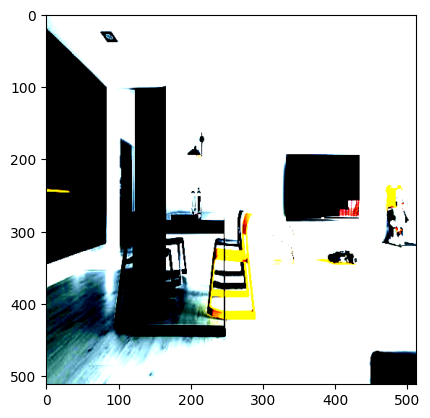

In [251]:
plt.imshow( images[5].permute(1, 2, 0)  )


In [234]:
annotations[0]['filename']

'00494045.png'

In [325]:
hafm_encoder = HAFMencoder(cfg)

In [326]:
metas = hafm_encoder(annotations)

In [327]:
metas

[{'junc': tensor([[1.2395e+02, 0.0000e+00],
          [1.1552e+02, 1.2800e+02],
          [1.2201e+02, 2.3413e+01],
          [5.3954e+01, 2.4385e+01],
          [4.2667e+00, 0.0000e+00],
          [5.3738e+01, 7.0886e+01],
          [1.1876e+02, 7.5423e+01],
          [1.0417e-04, 9.3732e+01],
          [6.0868e+01, 1.2792e+02],
          [1.6202e-01, 1.1852e+02]]),
  'Lpos': tensor([[False,  True, False, False, False, False, False, False, False, False,
           False],
          [ True, False, False, False, False, False, False, False, False, False,
           False],
          [False, False, False,  True, False, False, False, False, False, False,
           False],
          [False, False,  True, False,  True,  True, False, False, False, False,
           False],
          [False, False, False,  True, False, False, False, False, False, False,
           False],
          [False, False, False,  True, False, False,  True,  True, False, False,
           False],
          [False, Fals

In [45]:
(metas[0]).keys()

dict_keys(['junc', 'Lpos', 'Lneg', 'lpre', 'lpre_label', 'lines'])

In [243]:
metas[1]['lines']

tensor([[1.0404e+02, 8.0922e+01, 1.2274e+02, 7.4907e+01],
        [1.2274e+02, 7.4907e+01, 1.2766e+02, 1.2290e+02],
        [1.2766e+02, 1.2290e+02, 1.0274e+02, 1.1582e+02],
        [1.0274e+02, 1.1582e+02, 1.0085e+02, 1.0002e+02],
        [8.3351e+01, 8.1318e+01, 1.0300e+02, 7.2725e+01],
        [1.0300e+02, 7.2725e+01, 1.0516e+02, 9.9166e+01],
        [1.0516e+02, 9.9166e+01, 8.4644e+01, 9.9298e+01],
        [8.3351e+01, 8.1318e+01, 8.4644e+01, 9.9298e+01],
        [8.5678e+01, 7.9534e+01, 7.7909e+01, 7.9393e+01],
        [7.7909e+01, 7.9393e+01, 1.2783e+02, 4.6153e+01],
        [7.7909e+01, 7.9393e+01, 7.7317e+01, 5.3027e+01],
        [7.7317e+01, 5.3027e+01, 1.1317e+02, 9.3996e-01],
        [1.2740e+02, 6.4264e+01, 1.1593e+02, 6.9817e+01],
        [1.1593e+02, 6.9817e+01, 1.1214e+02, 6.9817e+01],
        [1.1214e+02, 6.9817e+01, 1.2386e+02, 6.3802e+01],
        [1.2740e+02, 6.4264e+01, 1.2386e+02, 6.3802e+01],
        [5.4303e+01, 4.8929e+01, 5.9561e+01, 4.2319e+01],
        [5.956

In [242]:
metas[1]['junc']

tensor([[1.0404e+02, 8.0922e+01],
        [1.2274e+02, 7.4907e+01],
        [1.2766e+02, 1.2290e+02],
        [1.0274e+02, 1.1582e+02],
        [1.0085e+02, 1.0002e+02],
        [8.3351e+01, 8.1318e+01],
        [1.0300e+02, 7.2725e+01],
        [1.0516e+02, 9.9166e+01],
        [8.4644e+01, 9.9298e+01],
        [8.5678e+01, 7.9534e+01],
        [7.7909e+01, 7.9393e+01],
        [1.2783e+02, 4.6153e+01],
        [7.7317e+01, 5.3027e+01],
        [1.1317e+02, 9.3996e-01],
        [1.2740e+02, 6.4264e+01],
        [1.1593e+02, 6.9817e+01],
        [1.1214e+02, 6.9817e+01],
        [1.2386e+02, 6.3802e+01],
        [5.4303e+01, 4.8929e+01],
        [5.9561e+01, 4.2319e+01],
        [5.6544e+01, 3.9807e+01],
        [5.0941e+01, 4.6682e+01],
        [5.0941e+01, 4.3377e+01],
        [5.6630e+01, 3.6767e+01],
        [5.9733e+01, 3.9675e+01],
        [3.8874e+01, 5.6992e+00],
        [4.2408e+01, 5.2961e+01],
        [6.0423e+01, 5.5341e+01],
        [7.2921e+01, 1.4491e+01],
        [2.439

In [46]:
annotations[0].keys()

dict_keys(['junctions', 'height', 'filename', 'width', 'edges_negative', 'edges_positive', 'reminder'])

In [245]:
annotations[1]['junctions'].shape

torch.Size([103, 2])

In [248]:
metas[1]['junc'].shape

torch.Size([103, 2])

In [250]:
for i in range(6):
    print(metas[i]['Lpos'].shape)

torch.Size([11, 11])
torch.Size([104, 104])
torch.Size([79, 79])
torch.Size([68, 68])
torch.Size([39, 39])
torch.Size([55, 55])


In [91]:
(metas[0]['lpre']).shape

torch.Size([125, 4])

In [69]:
(metas[0]['Lpos']).numpy()[39].tolist().index(True)

38

In [95]:
lpos = metas[0]['Lpos']
lneg = metas[0]['Lneg']

In [97]:
_swap

tensor([False, False, False,  True,  True,  True, False,  True, False,  True,
         True,  True,  True,  True, False, False,  True,  True,  True,  True,
         True,  True, False, False, False, False,  True, False, False, False,
        False, False, False,  True,  True, False,  True,  True, False,  True,
        False,  True, False,  True, False, False,  True,  True, False, False,
        False,  True,  True,  True,  True,  True, False,  True, False,  True,
         True, False,  True,  True,  True, False, False,  True, False, False,
        False,  True, False, False,  True, False, False, False,  True,  True,
         True, False,  True, False, False, False,  True,  True, False, False,
         True, False, False,  True, False,  True, False, False, False,  True,
        False,  True, False,  True, False, False,  True, False, False, False,
        False,  True,  True, False, False,  True, False,  True,  True,  True,
         True, False, False,  True,  True, False, False,  True, 

In [112]:
lpre[_swap]

tensor([[False, False,  True,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ...,  True,  True, False],
        [ True,  True, False,  ...,  True,  True, False],
        [False, False, False,  ...,  True, False, False]])

In [96]:
lpre = torch.cat((lpos,lneg),dim=0)
_swap = (torch.rand(lpre.size(0))>0.5).to(device)
lpre[_swap] = lpre[_swap][:,[2,3,0,1]]
lpre_label = torch.cat(
    [
        torch.ones(lpos.size(0),device=device),
        torch.zeros(lneg.size(0),device=device)
     ])


RuntimeError: shape mismatch: value tensor of shape [99, 4] cannot be broadcast to indexing result of shape [99, 115]

In [71]:
(metas[0]['Lpos']).numpy()[0].tolist().index(True)

1

In [432]:
index = 1
junctions = annotations[index]['junctions']
edges_positive = annotations[index]['edges_positive']
edges_negative = annotations[index]['edges_negative']

lines = torch.cat((junctions[edges_positive[:,0]], junctions[edges_positive[:,1]]),dim=-1)


In [ ]:
end points - left and right
line central point, line
shift vector)

In [438]:
lines/128

tensor([[8.1279e-01, 6.3220e-01, 9.5892e-01, 5.8521e-01],
        [9.5892e-01, 5.8521e-01, 9.9731e-01, 9.6012e-01],
        [9.9731e-01, 9.6012e-01, 8.0269e-01, 9.0487e-01],
        [8.0269e-01, 9.0487e-01, 7.8788e-01, 7.8144e-01],
        [6.5118e-01, 6.3530e-01, 8.0471e-01, 5.6817e-01],
        [8.0471e-01, 5.6817e-01, 8.2155e-01, 7.7473e-01],
        [8.2155e-01, 7.7473e-01, 6.6128e-01, 7.7576e-01],
        [6.5118e-01, 6.3530e-01, 6.6128e-01, 7.7576e-01],
        [6.6936e-01, 6.2136e-01, 6.0866e-01, 6.2026e-01],
        [6.0866e-01, 6.2026e-01, 9.9865e-01, 3.6057e-01],
        [6.0866e-01, 6.2026e-01, 6.0404e-01, 4.1428e-01],
        [6.0404e-01, 4.1428e-01, 8.8418e-01, 7.3434e-03],
        [9.9529e-01, 5.0207e-01, 9.0572e-01, 5.4544e-01],
        [9.0572e-01, 5.4544e-01, 8.7609e-01, 5.4544e-01],
        [8.7609e-01, 5.4544e-01, 9.6768e-01, 4.9845e-01],
        [9.9529e-01, 5.0207e-01, 9.6768e-01, 4.9845e-01],
        [4.2424e-01, 3.8226e-01, 4.6532e-01, 3.3062e-01],
        [4.653

In [439]:
lines

tensor([[1.0404e+02, 8.0922e+01, 1.2274e+02, 7.4907e+01],
        [1.2274e+02, 7.4907e+01, 1.2766e+02, 1.2290e+02],
        [1.2766e+02, 1.2290e+02, 1.0274e+02, 1.1582e+02],
        [1.0274e+02, 1.1582e+02, 1.0085e+02, 1.0002e+02],
        [8.3351e+01, 8.1318e+01, 1.0300e+02, 7.2725e+01],
        [1.0300e+02, 7.2725e+01, 1.0516e+02, 9.9166e+01],
        [1.0516e+02, 9.9166e+01, 8.4644e+01, 9.9298e+01],
        [8.3351e+01, 8.1318e+01, 8.4644e+01, 9.9298e+01],
        [8.5678e+01, 7.9534e+01, 7.7909e+01, 7.9393e+01],
        [7.7909e+01, 7.9393e+01, 1.2783e+02, 4.6153e+01],
        [7.7909e+01, 7.9393e+01, 7.7317e+01, 5.3027e+01],
        [7.7317e+01, 5.3027e+01, 1.1317e+02, 9.3996e-01],
        [1.2740e+02, 6.4264e+01, 1.1593e+02, 6.9817e+01],
        [1.1593e+02, 6.9817e+01, 1.1214e+02, 6.9817e+01],
        [1.1214e+02, 6.9817e+01, 1.2386e+02, 6.3802e+01],
        [1.2740e+02, 6.4264e+01, 1.2386e+02, 6.3802e+01],
        [5.4303e+01, 4.8929e+01, 5.9561e+01, 4.2319e+01],
        [5.956

In [442]:
(lines[:,:2]+lines[:,2:])/2

tensor([[113.3899,  77.9142],
        [125.1987,  98.9012],
        [115.2000, 119.3593],
        [101.7966, 107.9239],
        [ 93.1771,  77.0218],
        [104.0808,  85.9454],
        [ 94.9010,  99.2317],
        [ 83.9973,  90.3081],
        [ 81.7933,  79.4635],
        [102.8681,  62.7730],
        [ 77.6129,  66.2103],
        [ 95.2458,  26.9836],
        [121.6646,  67.0406],
        [114.0364,  69.8169],
        [118.0014,  66.8093],
        [125.6296,  64.0331],
        [ 56.9320,  45.6240],
        [ 58.0525,  41.0631],
        [ 53.7428,  43.2444],
        [ 50.9414,  45.0291],
        [ 53.7859,  40.0716],
        [ 56.5872,  38.2868],
        [ 58.1818,  38.2207],
        [ 59.6471,  40.9970],
        [ 52.6222,  47.8053],
        [ 40.6411,  29.3302],
        [ 51.4155,  54.1510],
        [ 66.6721,  34.9157],
        [ 55.8976,  10.0949],
        [ 24.0916, 111.6586],
        [ 51.9758, 125.1431],
        [ 78.6532,  94.2080],
        [ 54.3030,  99.1656],
        [ 

In [65]:
annotations[0]['edges_positive']

tensor([[0, 1],
        [2, 3],
        [3, 4],
        [3, 5],
        [5, 6],
        [5, 7],
        [8, 9]])

In [68]:
annotations[0]['junctions']

tensor([[1.2395e+02, 0.0000e+00],
        [1.1552e+02, 1.2800e+02],
        [1.2201e+02, 2.3413e+01],
        [5.3954e+01, 2.4385e+01],
        [4.2667e+00, 0.0000e+00],
        [5.3738e+01, 7.0886e+01],
        [1.1876e+02, 7.5423e+01],
        [1.0417e-04, 9.3732e+01],
        [6.0868e+01, 1.2792e+02],
        [1.6202e-01, 1.1852e+02]])

In [42]:
jmap = torch.zeros((annotations[0]['height'],annotations[0]['width']),device=device)
joff = torch.zeros((2,annotations[0]['height'],annotations[0]['width']),device=device,dtype=torch.float32)
        
xint,yint = annotations[0]['junctions'][:,0].long(), annotations[0]['junctions'][:,1].long()
off_x = annotations[0]['junctions'][:,0] - xint.float()-0.5
off_y = annotations[0]['junctions'][:,1] - yint.float()-0.5

jmap[yint,xint] = 1
joff[0,yint,xint] = off_x
joff[1,yint,xint] = off_y

In [123]:
annotations[0]['junctions'][:,0]

tensor([127.9243, 117.3207, 117.0178, 127.6213, 127.9999,  24.5443,  12.3456,
         12.4301,  18.8592,  96.1136,  73.2322,  73.2402,  94.4184,  94.3252,
          0.1480,   3.1075,   1.6277,  15.5376,  15.2416,  40.3977,  40.2497,
         38.6220,  38.8249,  47.5006,  92.9471,  46.8336,  99.0897, 106.0994,
        120.1572, 106.6913,  93.3734,  98.9965, 125.1884, 107.5519, 107.8751,
        107.8430, 126.3723, 126.4184, 111.5783, 117.3457, 110.3908, 117.1977,
        110.3816, 112.8092,  61.4104,  61.5584, 104.4717, 104.3237,  83.1008,
         94.2613,  99.5884,  23.4835,  31.8150,  32.6946,  25.1561,  46.8837,
        126.3775, 123.1816, 123.3944, 119.9252, 126.5202,  54.1057,  61.3795,
         46.9829,  48.9869,  48.9674,  51.0897,  51.0512, 120.1187, 113.0299,
        126.3535, 121.1954, 121.6000, 112.5150, 115.1632, 112.0299, 111.7767,
        111.7907, 111.9752, 119.3271, 109.3577, 126.0651, 109.3954, 117.2341,
         82.1085,  36.6636,  54.0149,  47.4791,  54.0279,  48.47

In [121]:
annotations[0]['junctions'][:,0].long()

tensor([127, 117, 117, 127, 127,  24,  12,  12,  18,  96,  73,  73,  94,  94,
          0,   3,   1,  15,  15,  40,  40,  38,  38,  47,  92,  46,  99, 106,
        120, 106,  93,  98, 125, 107, 107, 107, 126, 126, 111, 117, 110, 117,
        110, 112,  61,  61, 104, 104,  83,  94,  99,  23,  31,  32,  25,  46,
        126, 123, 123, 119, 126,  54,  61,  46,  48,  48,  51,  51, 120, 113,
        126, 121, 121, 112, 115, 112, 111, 111, 111, 119, 109, 126, 109, 117,
         82,  36,  54,  47,  54,  48, 119, 126, 109, 109, 109, 119, 126, 122,
        123, 123, 121,  80,  80,  84,  92,  95,   0,   7,   0,   6,  12,   0,
        124, 126])

In [122]:
off_x

tensor([ 0.4243, -0.1793, -0.4822,  0.1213,  0.4999,  0.0443, -0.1544, -0.0699,
         0.3592, -0.3864, -0.2678, -0.2598, -0.0816, -0.1748, -0.3520, -0.3925,
         0.1277,  0.0376, -0.2584, -0.1023, -0.2503,  0.1220,  0.3249,  0.0006,
         0.4471,  0.3336, -0.4103, -0.4006, -0.3428,  0.1913, -0.1266,  0.4965,
        -0.3116,  0.0519,  0.3751,  0.3430, -0.1277, -0.0816,  0.0783, -0.1543,
        -0.1092, -0.3023, -0.1184,  0.3092, -0.0896,  0.0584, -0.0283, -0.1763,
        -0.3992, -0.2387,  0.0884, -0.0165,  0.3150,  0.1946, -0.3439,  0.3837,
        -0.1225, -0.3184, -0.1056,  0.4252,  0.0202, -0.3943, -0.1205,  0.4829,
         0.4869,  0.4674, -0.4103, -0.4488, -0.3813, -0.4701, -0.1465, -0.3046,
         0.1000,  0.0150, -0.3368, -0.4701,  0.2767,  0.2907,  0.4752, -0.1729,
        -0.1423, -0.4349, -0.1046, -0.2659, -0.3915,  0.1636, -0.4851, -0.0209,
        -0.4721, -0.0287,  0.2147, -0.2364, -0.0380, -0.3031, -0.0361,  0.0163,
        -0.0380, -0.2054,  0.1837,  0.08

In [126]:
jmap.shape

torch.Size([128, 128])

In [129]:
joff[0][9]

tensor([-0.5000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

# Hourglassnet

In [28]:
"""
Hourglass network inserted in the pre-activated Resnet
Use lr=0.01 for current version
(c) Nan Xue (HAWP)
(c) Yichao Zhou (LCNN)
(c) YANG, Wei
"""
import torch
import torch.nn as nn
import torch.nn.functional as F

__all__ = ["HourglassNet", "hg"]


class Bottleneck2D(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck2D, self).__init__()

        self.bn1 = nn.BatchNorm2d(inplanes)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 2, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        return out


class Hourglass(nn.Module):
    def __init__(self, block, num_blocks, planes, depth):
        super(Hourglass, self).__init__()
        self.depth = depth
        self.block = block
        self.hg = self._make_hour_glass(block, num_blocks, planes, depth)

    def _make_residual(self, block, num_blocks, planes):
        layers = []
        for i in range(0, num_blocks):
            layers.append(block(planes * block.expansion, planes))
        return nn.Sequential(*layers)

    def _make_hour_glass(self, block, num_blocks, planes, depth):
        hg = []
        for i in range(depth):
            res = []
            for j in range(3):
                res.append(self._make_residual(block, num_blocks, planes))
            if i == 0:
                res.append(self._make_residual(block, num_blocks, planes))
            hg.append(nn.ModuleList(res))
        return nn.ModuleList(hg)

    def _hour_glass_forward(self, n, x):
        up1 = self.hg[n - 1][0](x)
        low1 = F.max_pool2d(x, 2, stride=2)
        low1 = self.hg[n - 1][1](low1)

        if n > 1:
            low2 = self._hour_glass_forward(n - 1, low1)
        else:
            low2 = self.hg[n - 1][3](low1)
        low3 = self.hg[n - 1][2](low2)
        up2 = F.interpolate(low3, scale_factor=2)
        out = up1 + up2
        return out

    def forward(self, x):
        return self._hour_glass_forward(self.depth, x)


class HourglassNet(nn.Module):
    """Hourglass model from Newell et al ECCV 2016"""

    def __init__(self, inplanes, num_feats, block, head, depth, num_stacks, num_blocks, num_classes):
        super(HourglassNet, self).__init__()

        self.inplanes = inplanes
        self.num_feats = num_feats
        self.num_stacks = num_stacks
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_residual(block, self.inplanes, 1)
        self.layer2 = self._make_residual(block, self.inplanes, 1)
        self.layer3 = self._make_residual(block, self.num_feats, 1)
        self.maxpool = nn.MaxPool2d(2, stride=2)

        # build hourglass modules
        ch = self.num_feats * block.expansion

        hg, res, fc, score, fc_, score_ = [], [], [], [], [], []
        for i in range(num_stacks):
            hg.append(Hourglass(block, num_blocks, self.num_feats, depth))
            res.append(self._make_residual(block, self.num_feats, num_blocks))
            fc.append(self._make_fc(ch, ch))
            score.append(head(ch, num_classes))
            
            if i < num_stacks - 1:
                fc_.append(nn.Conv2d(ch, ch, kernel_size=1))
                score_.append(nn.Conv2d(num_classes, ch, kernel_size=1))
                
        self.hg = nn.ModuleList(hg)
        self.res = nn.ModuleList(res)
        self.fc = nn.ModuleList(fc)
        self.score = nn.ModuleList(score)
        # self.vpts = nn.ModuleList(vpts)
        self.fc_ = nn.ModuleList(fc_)
        self.score_ = nn.ModuleList(score_)

    def _make_residual(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.inplanes,
                    planes * block.expansion,
                    kernel_size=1,
                    stride=stride,
                )
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _make_fc(self, inplanes, outplanes):
        bn = nn.BatchNorm2d(inplanes)
        conv = nn.Conv2d(inplanes, outplanes, kernel_size=1)
        return nn.Sequential(conv, bn, self.relu)

    def forward(self, x):
        out = []
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.maxpool(x)
        x = self.layer2(x)
        x = self.layer3(x)

        for i in range(self.num_stacks):
            y = self.hg[i](x)
            y = self.res[i](y)
            y = self.fc[i](y)
            score = self.score[i](y)
            out.append(score)

            if i < self.num_stacks - 1:
                fc_ = self.fc_[i](y)
                score_ = self.score_[i](score)
                x = x + fc_ + score_

        return out[::-1], y 


In [32]:
from parsing.backbones.registry import MODELS
# from .stacked_hg import HourglassNet, Bottleneck2D
from parsing.backbones.multi_task_head import MultitaskHead

# @MODELS.register("Hourglass")
# def build_hg(cfg):
#     inplanes = cfg.MODEL.HGNETS.INPLANES
#     num_feats = cfg.MODEL.OUT_FEATURE_CHANNELS//2
#     depth = cfg.MODEL.HGNETS.DEPTH
#     num_stacks = cfg.MODEL.HGNETS.NUM_STACKS
#     num_blocks = cfg.MODEL.HGNETS.NUM_BLOCKS
#     head_size = cfg.MODEL.HEAD_SIZE

#     out_feature_channels = cfg.MODEL.OUT_FEATURE_CHANNELS


#     num_class = sum(sum(head_size, []))
#     model = HourglassNet(
#         block=Bottleneck2D,
#         inplanes = inplanes,
#         num_feats= num_feats,
#         depth=depth,
#         head=lambda c_in, c_out: MultitaskHead(c_in, c_out, head_size=head_size),
#         num_stacks = num_stacks,
#         num_blocks = num_blocks,
#         num_classes = num_class)

#     model.out_feature_channels = out_feature_channels

#     return model


# def build_backbone(cfg):
#     assert cfg.MODEL.NAME in MODELS,  \
#         "cfg.MODELS.NAME: {} is not registered in registry".format(cfg.MODELS.NAME)

#     return MODELS[cfg.MODEL.NAME](cfg)

In [33]:
# from parsing.backbones import build_backbone
# outputs, features = build_backbone(images)

In [34]:
inplanes = cfg.MODEL.HGNETS.INPLANES
num_feats = cfg.MODEL.OUT_FEATURE_CHANNELS//2
depth = cfg.MODEL.HGNETS.DEPTH
num_stacks = cfg.MODEL.HGNETS.NUM_STACKS
num_blocks = cfg.MODEL.HGNETS.NUM_BLOCKS
head_size = cfg.MODEL.HEAD_SIZE

out_feature_channels = cfg.MODEL.OUT_FEATURE_CHANNELS


num_class = sum(sum(head_size, []))
model = HourglassNet(
    block=Bottleneck2D,
    inplanes = inplanes,
    num_feats= num_feats,
    depth=depth,
    head=lambda c_in, c_out: MultitaskHead(c_in, c_out, head_size=head_size),
    num_stacks = num_stacks,
    num_blocks = num_blocks,
    num_classes = num_class)

model.out_feature_channels = out_feature_channels


In [35]:
hg_outputs,features=model(images)

In [37]:
len(hg_outputs)

2

In [39]:
hg_outputs[0][0].shape

torch.Size([9, 128, 128])

In [40]:
hg_outputs[1].shape

torch.Size([6, 9, 128, 128])

In [43]:
joff.shape

torch.Size([2, 128, 128])

In [44]:
(hg_outputs[0][0][:,3:4]).shape

torch.Size([9, 1, 128])

In [428]:
loi_features = nn.Conv2d(256, 128, 1)(features)
hg_output = hg_outputs[0]
#md angles, perp. distance, residual
md_pred = hg_output[:,:3].sigmoid()
dis_pred = hg_output[:,3:4].sigmoid()
res_pred = hg_output[:,4:5].sigmoid()
jloc_pred= hg_output[:,5:7].softmax(1)[:,1:]
joff_pred= hg_output[:,7:9].sigmoid() - 0.5

lines_batch = []
extra_info = {
}

batch_size = md_pred.size(0)

for i, (md_pred_per_im, dis_pred_per_im,res_pred_per_im,meta) in enumerate(zip(md_pred, dis_pred,res_pred,metas)):
    lines_pred = []
    for scale in [-1.0,0.0,1.0]:
        _ = WireframeDetector.proposal_lines(0,md_pred_per_im, dis_pred_per_im+scale*res_pred_per_im).view(-1, 4)
        lines_pred.append(_)

    lines_pred = torch.cat(lines_pred)
    junction_gt = meta['junc']
    N = junction_gt.size(0)

    juncs_pred, _ = get_junctions(non_maximum_suppression(jloc_pred[i]),joff_pred[i], topk=min(N*2+2,300))
    dis_junc_to_end1, idx_junc_to_end1 = torch.sum((lines_pred[:,:2]-juncs_pred[:,None])**2,dim=-1).min(0)
    dis_junc_to_end2, idx_junc_to_end2 = torch.sum((lines_pred[:, 2:] - juncs_pred[:, None]) ** 2, dim=-1).min(0)

    idx_junc_to_end_min = torch.min(idx_junc_to_end1,idx_junc_to_end2)
    idx_junc_to_end_max = torch.max(idx_junc_to_end1,idx_junc_to_end2)
    iskeep = idx_junc_to_end_min<idx_junc_to_end_max
    idx_lines_for_junctions = torch.cat((idx_junc_to_end_min[iskeep,None],idx_junc_to_end_max[iskeep,None]),dim=1).unique(dim=0)
    idx_lines_for_junctions_mirror = torch.cat((idx_lines_for_junctions[:,1,None],idx_lines_for_junctions[:,0,None]),dim=1)
    idx_lines_for_junctions = torch.cat((idx_lines_for_junctions, idx_lines_for_junctions_mirror))
    lines_adjusted = torch.cat((juncs_pred[idx_lines_for_junctions[:,0]], juncs_pred[idx_lines_for_junctions[:,1]]),dim=1)

    cost_, match_ = torch.sum((juncs_pred-junction_gt[:,None])**2,dim=-1).min(0)
    match_[cost_>1.5*1.5] = N
    Lpos = meta['Lpos']
    Lneg = meta['Lneg']
    labels = Lpos[match_[idx_lines_for_junctions[:,0]],match_[idx_lines_for_junctions[:,1]]]

    iskeep = torch.zeros_like(labels, dtype= torch.bool)
    cdx = labels.nonzero().flatten()

    if len(cdx) > 300:
        perm = torch.randperm(len(cdx),device=device)[:300]
        cdx = cdx[perm]

    iskeep[cdx] = 1

    if 0 > 0:
        cdx = Lneg[match_[idx_lines_for_junctions[:,0]],match_[idx_lines_for_junctions[:,1]]].nonzero().flatten()

        if len(cdx) > self.n_dyn_negl:
            perm = torch.randperm(len(cdx), device=device)[:self.n_dyn_negl]
            cdx = cdx[perm]

        iskeep[cdx] = 1

    if 0 > 0 :
        cdx = torch.randint(len(iskeep), (self.n_dyn_othr,), device=device)
        iskeep[cdx] = 1

    if 300 >0 :
        cdx = (labels==0).nonzero().flatten()
        if len(cdx) > 300:
            perm = torch.randperm(len(cdx), device=device)[:300]
            cdx = cdx[perm]
        iskeep[cdx] = 1

    lines_selected = lines_adjusted[iskeep]
    labels_selected = labels[iskeep]

    lines_for_train = torch.cat((lines_selected,meta['lpre']))
    labels_for_train = torch.cat((labels_selected.float(),meta['lpre_label']))

    logits = WireframeDetector.pooling(0,loi_features[i],lines_for_train)

    loss_ = sigmoid_l1_loss(logits, labels_for_train)

    loss_positive = loss_[labels_for_train==1].mean()
    loss_negative = loss_[labels_for_train==0].mean()

#     loss_dict['loss_pos'] += loss_positive/batch_size
#     loss_dict['loss_neg'] += loss_negative/batch_size

In [232]:
match_[idx_lines_for_junctions[:,0]].shape

torch.Size([958])

In [230]:
Lpos

tensor([[False,  True, False,  ..., False, False, False],
        [ True, False,  True,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False,  True, False],
        [False, False, False,  ...,  True, False, False],
        [False, False, False,  ..., False, False, False]])

In [324]:
cost_, match_ = torch.sum((juncs_pred-junction_gt[:,None])**2,dim=-1).min(0)


In [427]:
(lines_for_train[1][:2])

tensor([54.5249, 40.4828], grad_fn=<SliceBackward0>)

In [268]:
hash(lines_for_train[1][2:])

140305880788432

In [259]:
str(lines_for_train[0][:2])[7:-27]

'[54.5249, 40.4828]'

In [258]:
len(', grad_fn=<SliceBackward0>)')

27

In [260]:
streetno = {}
streetno[str(lines_for_train[0][:2])[7:-27]] = 0

In [429]:
lines

array([1.04037712e+02, 8.09217682e+01, 1.22742088e+02, 7.49066086e+01,
       1.22742088e+02, 7.49066086e+01, 1.27655228e+02, 1.22895706e+02,
       1.27655228e+02, 1.22895706e+02, 1.02744789e+02, 1.15822937e+02,
       1.02744789e+02, 1.15822937e+02, 1.00848488e+02, 1.00024864e+02,
       8.33508453e+01, 8.13183746e+01, 1.03003372e+02, 7.27252884e+01,
       1.03003372e+02, 7.27252884e+01, 1.05158257e+02, 9.91655579e+01,
       1.05158257e+02, 9.91655579e+01, 8.46437759e+01, 9.92977600e+01,
       8.33508453e+01, 8.13183746e+01, 8.46437759e+01, 9.92977600e+01,
       8.56781235e+01, 7.95336533e+01, 7.79085541e+01, 7.93932800e+01,
       7.79085541e+01, 7.93932800e+01, 1.27827614e+02, 4.61528168e+01,
       7.79085541e+01, 7.93932800e+01, 7.73171768e+01, 5.30272903e+01,
       7.73171768e+01, 5.30272903e+01, 1.13174423e+02, 9.39956367e-01,
       1.27396637e+02, 6.42644043e+01, 1.15932663e+02, 6.98168564e+01,
       1.15932663e+02, 6.98168564e+01, 1.12140076e+02, 6.98168564e+01,
      

In [301]:
#O(n^2)
start = time.time() 

edge_index_1 = []
edge_index_2 = []
for l1 in range(lines_for_train.size(0)):
    for l2 in range(lines_for_train.size(0)):
        if (l1!=l2):
            if ((sum(lines_for_train[l1][:2] == lines_for_train[l2][:2])==2) or (sum(lines_for_train[l1][2:] == lines_for_train[l2][2:])==2)):
                edge_index_1.append(l1)
                edge_index_2.append(l2)

print('time:', time.time() - start)

time: 8.07209300994873


In [318]:
#O(n)*(degree of vertex)^2
from collections import defaultdict
start = time.time()
lines_graph_v1=[]
lines_graph_v2=[]
vertices_hash = defaultdict(list)

for idx,line in enumerate(lines_for_train):
    v1 = str(line[:2])[7:-27]
    v2 = str(line[2:])[7:-27]
    
    vertices_hash[v1].append(idx)
    vertices_hash[v2].append(idx)
    
    v1_lines = vertices_hash[v1]
    v2_lines = vertices_hash[v2]
    
    if (len(v1_lines)>1):
        for line in v1_lines[:-1]:
            lines_graph_v1.append(line)
            lines_graph_v2.append(idx)
#             lines_graph.append([line,idx])
    if (len(v2_lines)>1):
        for line in v2_lines[:-1]:
            lines_graph_v1.append(line)
            lines_graph_v2.append(idx)
#             lines_graph.append([line,idx])
        
print('time:', time.time() - start)

time: 0.14145898818969727


In [322]:
edge_index = torch.IntTensor([lines_graph_v1,lines_graph_v2])
edge_index

tensor([[  0,   0,   1,  ..., 307, 322, 310],
        [  1,   2,   2,  ..., 384, 384, 384]], dtype=torch.int32)

In [319]:
lines_graph

[[0, 1],
 [0, 2],
 [1, 2],
 [0, 3],
 [1, 3],
 [2, 3],
 [0, 4],
 [1, 4],
 [2, 4],
 [3, 4],
 [5, 6],
 [5, 7],
 [6, 7],
 [8, 9],
 [8, 10],
 [9, 10],
 [8, 11],
 [9, 11],
 [10, 11],
 [5, 12],
 [5, 13],
 [12, 13],
 [15, 16],
 [15, 17],
 [16, 17],
 [15, 18],
 [16, 18],
 [17, 18],
 [6, 19],
 [12, 19],
 [20, 21],
 [20, 22],
 [21, 22],
 [23, 24],
 [23, 25],
 [24, 25],
 [26, 27],
 [12, 27],
 [19, 27],
 [28, 29],
 [28, 30],
 [29, 30],
 [28, 32],
 [32, 33],
 [34, 35],
 [34, 36],
 [35, 36],
 [34, 37],
 [35, 37],
 [36, 37],
 [34, 38],
 [35, 38],
 [36, 38],
 [37, 38],
 [4, 38],
 [8, 39],
 [39, 40],
 [39, 41],
 [40, 41],
 [39, 42],
 [40, 42],
 [41, 42],
 [11, 42],
 [39, 43],
 [40, 43],
 [41, 43],
 [42, 43],
 [39, 44],
 [40, 44],
 [41, 44],
 [42, 44],
 [43, 44],
 [33, 44],
 [23, 45],
 [23, 46],
 [45, 46],
 [24, 46],
 [23, 47],
 [45, 47],
 [46, 47],
 [28, 48],
 [32, 48],
 [48, 49],
 [48, 50],
 [49, 50],
 [48, 51],
 [49, 51],
 [50, 51],
 [48, 52],
 [49, 52],
 [50, 52],
 [51, 52],
 [48, 53],
 [49, 53],
 [5

In [316]:
torch.IntTensor([edge_index_1,edge_index_2])[:,:14]

tensor([[  0,   0,   0,   0,   0,   1,   1,   1,   1,   1,   2,   2,   2,   2],
        [  1,   2,   3,   4, 183,   0,   2,   3,   4, 247,   0,   1,   3,   4]],
       dtype=torch.int32)

In [288]:
for k,v in vertices_hash.items():
  print (f"{k} - {v}")

[54.5249, 40.4828] - [0, 1, 2, 3, 4, 159]
[49.5126, 34.5040] - [0, 183]
[59.5089, 47.4910] - [1, 90, 159, 230, 247]
[50.4817, 56.4902] - [2, 134, 191, 276]
[46.4984, 43.4622] - [3, 113, 134, 145, 150, 151, 190, 205, 254, 261, 289, 292, 293]
[53.5182, 46.4940] - [4, 38, 194, 200]
[20.5325,  4.4567] - [5, 6, 7, 160, 161, 162]
[22.5564,  3.4584] - [5, 12, 13, 160, 165, 166]
[24.4802, 13.4508] - [6, 19, 165, 173, 174]
[19.5249,  2.4569] - [7, 161, 188]
[127.5030,  64.5183] - [8, 9, 10, 11, 163, 164]
[122.5483,  67.4561] - [8, 39, 74, 75, 76, 229]
[127.4593,  66.5307] - [9]
[124.5416,  66.4433] - [10, 61, 74, 136, 217, 229]
[127.4723,  78.4758] - [11, 42, 62, 76, 120, 164, 202, 269]
[25.5003, 11.4561] - [12, 19, 27, 125, 166]
[24.5261,  7.4847] - [13, 73, 126, 140, 188, 222, 275, 278, 283, 286]
[ 7.4897, 58.4672] - [14, 167, 168]
[ 1.4216, 63.4440] - [14, 122, 270, 287]
[30.4999,  4.4595] - [15, 16, 17, 18, 169, 170, 171, 172]
[30.4995,  0.4528] - [15, 56, 57, 211, 212]
[35.5141, 22.4859] -

In [214]:
match_[cost_>1.5*1.5] = N

In [215]:
match_

tensor([54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54,
        54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54,
        54, 18, 54, 54, 31, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54,
        54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 42, 54,
        54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 14, 54, 54,
        54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54,
        54, 54])

In [228]:
junction_gt

tensor([[6.1726e+01, 1.1102e+02],
        [2.9888e+01, 1.1102e+02],
        [3.0148e+01, 7.1805e+01],
        [4.4703e+01, 6.7902e+01],
        [6.1726e+01, 6.7902e+01],
        [6.1726e+01, 7.1415e+01],
        [2.0792e+01, 7.9219e+01],
        [1.2995e-01, 8.6439e+01],
        [1.2774e+02, 2.4391e+01],
        [2.0792e+01, 2.5562e+01],
        [2.5990e-01, 5.2692e+00],
        [2.1052e+01, 8.8390e+01],
        [2.3131e+01, 8.6829e+01],
        [2.2871e+01, 2.5952e+01],
        [1.3515e+01, 8.8000e+01],
        [1.3515e+01, 8.2536e+01],
        [1.2995e-01, 9.4243e+01],
        [4.1584e+01, 6.8293e+01],
        [4.1584e+01, 2.5171e+01],
        [1.0825e+02, 7.1219e+01],
        [1.0838e+02, 4.8586e+01],
        [8.3297e+01, 4.8195e+01],
        [8.3038e+01, 7.1219e+01],
        [1.2787e+02, 8.8585e+01],
        [4.1435e+01, 8.8899e+01],
        [4.1584e+01, 7.5902e+01],
        [1.2800e+02, 1.1668e+02],
        [1.1254e+02, 1.1629e+02],
        [1.2545e+02, 1.2760e+02],
        [1.118

In [187]:
match_.shape

torch.Size([110])

In [198]:
junction_gt[:,None]

tensor([[[6.1726e+01, 1.1102e+02]],

        [[2.9888e+01, 1.1102e+02]],

        [[3.0148e+01, 7.1805e+01]],

        [[4.4703e+01, 6.7902e+01]],

        [[6.1726e+01, 6.7902e+01]],

        [[6.1726e+01, 7.1415e+01]],

        [[2.0792e+01, 7.9219e+01]],

        [[1.2995e-01, 8.6439e+01]],

        [[1.2774e+02, 2.4391e+01]],

        [[2.0792e+01, 2.5562e+01]],

        [[2.5990e-01, 5.2692e+00]],

        [[2.1052e+01, 8.8390e+01]],

        [[2.3131e+01, 8.6829e+01]],

        [[2.2871e+01, 2.5952e+01]],

        [[1.3515e+01, 8.8000e+01]],

        [[1.3515e+01, 8.2536e+01]],

        [[1.2995e-01, 9.4243e+01]],

        [[4.1584e+01, 6.8293e+01]],

        [[4.1584e+01, 2.5171e+01]],

        [[1.0825e+02, 7.1219e+01]],

        [[1.0838e+02, 4.8586e+01]],

        [[8.3297e+01, 4.8195e+01]],

        [[8.3038e+01, 7.1219e+01]],

        [[1.2787e+02, 8.8585e+01]],

        [[4.1435e+01, 8.8899e+01]],

        [[4.1584e+01, 7.5902e+01]],

        [[1.2800e+02, 1.1668e+02]],

 

In [181]:
idx_lines_for_junctions[iskeep].shape

torch.Size([300, 2])

In [185]:
labels_for_train.shape

torch.Size([385])

In [426]:
lines.shape

(364,)

In [182]:
idx_lines_for_junctions[iskeep]

tensor([[  0,  11],
        [  0,  42],
        [  0,  63],
        [  0,  85],
        [  0, 107],
        [  1,   3],
        [  1,   6],
        [  1,  13],
        [  2,  34],
        [  2,  51],
        [  2,  65],
        [  2,  79],
        [  3,  74],
        [  3,  86],
        [  4,  99],
        [  5,  24],
        [  5,  28],
        [  5,  32],
        [  5,  69],
        [  6,  74],
        [  8,  66],
        [  8,  67],
        [  8,  89],
        [  9,  19],
        [  9,  76],
        [  9,  95],
        [ 10,  64],
        [ 10,  74],
        [ 14,  26],
        [ 14,  84],
        [ 14,  91],
        [ 15, 101],
        [ 16,  26],
        [ 16,  94],
        [ 17,  37],
        [ 17,  46],
        [ 17,  50],
        [ 17,  92],
        [ 17, 107],
        [ 18,  34],
        [ 18,  35],
        [ 18,  68],
        [ 18,  79],
        [ 18,  90],
        [ 18,  94],
        [ 19,  36],
        [ 19,  76],
        [ 19,  87],
        [ 21,  26],
        [ 21,  47],


In [177]:
meta['lpre']

tensor([[2.9888e+01, 1.1102e+02, 3.1582e+01, 1.0766e+02],
        [1.1254e+02, 1.1629e+02, 1.2545e+02, 1.2760e+02],
        [6.1726e+01, 7.1415e+01, 6.1726e+01, 6.7902e+01],
        [6.1726e+01, 6.7902e+01, 4.4703e+01, 6.7902e+01],
        [2.5990e-01, 5.2692e+00, 2.0792e+01, 2.5562e+01],
        [2.2697e+01, 6.2103e+00, 1.8738e+01, 6.2103e+00],
        [2.1201e+01, 9.9088e+00, 2.4720e+01, 9.5125e+00],
        [3.1758e+01, 7.6218e+01, 3.1582e+01, 1.0766e+02],
        [1.3515e+01, 8.8000e+01, 2.1052e+01, 8.8390e+01],
        [2.5485e+01, 8.1747e+01, 2.3178e+01, 8.2613e+01],
        [1.3515e+01, 8.8000e+01, 1.2995e-01, 9.4243e+01],
        [4.1435e+01, 8.8899e+01, 1.2787e+02, 8.8585e+01],
        [4.1584e+01, 2.5171e+01, 4.1584e+01, 6.8293e+01],
        [3.2110e+01, 8.7050e+01, 4.1171e+01, 8.7182e+01],
        [4.1699e+01, 1.8495e+01, 1.2770e+02, 1.8283e+01],
        [4.1699e+01, 1.8495e+01, 3.4234e+01, 7.6991e-01],
        [8.3038e+01, 7.1219e+01, 1.0825e+02, 7.1219e+01],
        [1.082

In [137]:
lines_features=pooling_2(loi_features[i],lines_for_train)

In [174]:
lines_for_train.shape

torch.Size([385, 4])

In [115]:
lines_for_train

tensor([[ 54.5249,  40.4828,  55.5037,  55.4877],
        [ 54.5249,  40.4828,  51.4596,  51.4661],
        [ 20.5325,   4.4567,  22.5564,   3.4584],
        ...,
        [ 41.5838,  75.9023, 127.6970,  18.2833],
        [ 29.9107,  45.5733,  61.7259,  71.4145],
        [ 31.5821, 107.6560,   0.1300,  94.2435]], grad_fn=<CatBackward0>)

In [121]:
(lines_for_train[0][:2] == lines_for_train[1][:2])  == True

tensor([True, True])

In [146]:
edge_index = torch.IntTensor([edge_index_1,edge_index_2])
edge_index

tensor([[  0,   0,   0,  ..., 383, 383, 384],
        [  1,  31, 293,  ..., 356, 372, 310]], dtype=torch.int32)

In [138]:
lines_features

tensor([[ 0.3955,  0.4431,  0.5247,  ...,  0.5376,  0.7153,  0.4585],
        [ 0.6685,  0.7562,  0.7370,  ...,  0.4693,  0.4716,  0.2939],
        [ 1.0113,  1.0483,  1.0928,  ...,  0.0944,  0.1274,  0.1610],
        ...,
        [ 0.2697,  0.2553,  0.0047,  ...,  0.0216,  1.1124,  1.0423],
        [ 1.5104,  1.3678,  1.3920,  ..., -0.2474, -0.1807,  0.4779],
        [ 0.2292, -0.1815, -0.4428,  ...,  0.2082,  0.4443,  0.4089]],
       grad_fn=<ViewBackward0>)

In [139]:
edge_index.shape

torch.Size([2, 1822])

In [140]:
lines_features.shape

torch.Size([385, 1024])

In [157]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

conv1 = GCNConv(1024, 16)
conv2 = GCNConv(16, 1)

def forward(x,edge_index):

    x = conv1(x, edge_index)
    x = F.relu(x)
    output = F.sigmoid(conv2(x, edge_index))

    return output
    
    
# gcn = GCN()#.to(device)
# optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
# criterion = nn.CrossEntropyLoss()
# gcn = train_node_classifier(gcn, graph, optimizer_gcn, criterion)

# test_acc = eval_node_classifier(gcn, graph, graph.test_mask)
# print(f'Test Acc: {test_acc:.3f}')

In [158]:
forward(lines_features,edge_index)

tensor([[0.6921],
        [0.6594],
        [0.7432],
        [0.7417],
        [0.7435],
        [0.7683],
        [0.7642],
        [0.8475],
        [0.7848],
        [0.7872],
        [0.7015],
        [0.6903],
        [0.6346],
        [0.6360],
        [0.6544],
        [0.6321],
        [0.6361],
        [0.7335],
        [0.7288],
        [0.7278],
        [0.6132],
        [0.5923],
        [0.6555],
        [0.6665],
        [0.6720],
        [0.6528],
        [0.5922],
        [0.7736],
        [0.6921],
        [0.5755],
        [0.7261],
        [0.7175],
        [0.6868],
        [0.7051],
        [0.7188],
        [0.7429],
        [0.5925],
        [0.5680],
        [0.8464],
        [0.7304],
        [0.7855],
        [0.7985],
        [0.8235],
        [0.6456],
        [0.6450],
        [0.6566],
        [0.6470],
        [0.6360],
        [0.6429],
        [0.6752],
        [0.6307],
        [0.6663],
        [0.7580],
        [0.6292],
        [0.6582],
        [0

In [337]:
forward(lines_features,edge_index).view(-1).shape

torch.Size([385])

In [335]:
logits.shape

torch.Size([385])

In [160]:
logits

tensor([-0.0677, -0.0534, -0.1124, -0.0980, -0.0937, -0.1180, -0.0969, -0.0660,
        -0.0516, -0.0447, -0.1075, -0.0950, -0.0650, -0.0826, -0.0735, -0.0676,
        -0.0867, -0.0871, -0.0880, -0.1053, -0.0559, -0.0315, -0.0250, -0.0386,
        -0.0499, -0.0354, -0.0694, -0.0835, -0.0861, -0.0392, -0.0764, -0.0820,
        -0.0838, -0.0349, -0.0594, -0.0788, -0.0607, -0.0688, -0.0563, -0.0227,
        -0.0599, -0.0614, -0.0797, -0.0481, -0.0315, -0.0421, -0.0611, -0.0392,
        -0.0701, -0.0337, -0.0248, -0.0514, -0.0775, -0.0639, -0.0760, -0.0948,
        -0.0836, -0.0890, -0.0676, -0.0543, -0.0714, -0.0731, -0.0886, -0.0463,
        -0.0837, -0.0983, -0.0504, -0.0563, -0.0783, -0.0890, -0.0879, -0.0363,
        -0.0299, -0.0791, -0.0903, -0.0530, -0.0974, -0.0616, -0.0744, -0.0553,
        -0.0554, -0.0836, -0.0868, -0.1004, -0.0846, -0.0698, -0.0837, -0.0257,
        -0.1074, -0.0095, -0.0532, -0.0297, -0.0526, -0.0428, -0.0475, -0.0442,
        -0.0850, -0.0294, -0.0073, -0.06

In [162]:
forward(lines_features,edge_index).view(-1).shape

torch.Size([385])

In [95]:
lines_for_train #(x1,y1,x2,y2)

tensor([[ 54.5249,  40.4828,  55.5037,  55.4877],
        [ 54.5249,  40.4828,  51.4596,  51.4661],
        [ 20.5325,   4.4567,  22.5564,   3.4584],
        ...,
        [ 41.5838,  75.9023, 127.6970,  18.2833],
        [ 29.9107,  45.5733,  61.7259,  71.4145],
        [ 31.5821, 107.6560,   0.1300,  94.2435]], grad_fn=<CatBackward0>)

In [98]:
if (lines_for_train[0][0] != juncs_pred[0][0]):
    print(1)

In [109]:
jxns = set()
jxns.add((lines_for_train[0][0],lines_for_train[0][1]))

In [114]:
(lines_for_train[0][:2])

tensor([54.5249, 40.4828], grad_fn=<SliceBackward0>)

In [110]:
jxns

{(tensor(54.5249, grad_fn=<SelectBackward0>),
  tensor(40.4828, grad_fn=<SelectBackward0>))}

In [112]:
(lines_for_train[0][0],lines_for_train[0][1])

(tensor(54.5249, grad_fn=<SelectBackward0>),
 tensor(40.4828, grad_fn=<SelectBackward0>))

In [73]:
lines_for_train[:,:2]

tensor([[5.4525e+01, 4.0483e+01],
        [5.4525e+01, 4.0483e+01],
        [2.0532e+01, 4.4567e+00],
        [2.0532e+01, 4.4567e+00],
        [1.2750e+02, 6.4518e+01],
        [1.2750e+02, 6.4518e+01],
        [2.2556e+01, 3.4584e+00],
        [2.2556e+01, 3.4584e+00],
        [7.4897e+00, 5.8467e+01],
        [7.4897e+00, 5.8467e+01],
        [7.4897e+00, 5.8467e+01],
        [7.4897e+00, 5.8467e+01],
        [3.0500e+01, 4.4595e+00],
        [3.0500e+01, 4.4595e+00],
        [3.0500e+01, 4.4595e+00],
        [2.4480e+01, 1.3451e+01],
        [2.4480e+01, 1.3451e+01],
        [1.1456e+02, 1.1547e+02],
        [1.1456e+02, 1.1547e+02],
        [2.7486e+01, 7.2441e+01],
        [2.7486e+01, 7.2441e+01],
        [2.7486e+01, 7.2441e+01],
        [9.4863e+00, 6.2427e+01],
        [9.4863e+00, 6.2427e+01],
        [9.4863e+00, 6.2427e+01],
        [2.4531e+01, 2.4599e+00],
        [2.4531e+01, 2.4599e+00],
        [4.9513e+01, 3.4504e+01],
        [4.9513e+01, 3.4504e+01],
        [4.951

tensor([[  0,  11],
        [  0,  15],
        [  0,  25],
        ...,
        [109, 101],
        [108, 102],
        [109, 107]])

In [277]:
logits

tensor([ 0.0146,  0.0036,  0.0179,  0.0504,  0.0243,  0.0298,  0.0406,  0.0352,
         0.0161,  0.0443,  0.0114,  0.0217,  0.0322,  0.0056,  0.0180,  0.0164,
         0.0515,  0.0226,  0.0128,  0.0102,  0.0146,  0.0161,  0.0005,  0.0312,
         0.0485,  0.0239,  0.0119,  0.0177,  0.0351,  0.0067,  0.0117,  0.0184,
         0.0365,  0.0198,  0.0208,  0.0276,  0.0307,  0.0100,  0.0184,  0.0151,
         0.0220,  0.0161,  0.0140,  0.0149, -0.0081, -0.0116,  0.0273, -0.0003,
         0.0236,  0.0195,  0.0252,  0.0271,  0.0206,  0.0254,  0.0236,  0.0251,
         0.0332,  0.0288,  0.0353,  0.0491,  0.0537,  0.0220,  0.0210,  0.0251,
         0.0336,  0.0317,  0.0351,  0.0317,  0.0267,  0.0254,  0.0314,  0.0322,
         0.0351,  0.0284,  0.0265,  0.0253,  0.0326,  0.0273,  0.0373,  0.0183,
         0.0249, -0.0069,  0.0079,  0.0438,  0.0285,  0.0228,  0.0146,  0.0043,
         0.0332,  0.0280,  0.0335,  0.0421,  0.0422,  0.0287,  0.0351,  0.0445,
         0.0400,  0.0105,  0.0290,  0.03

In [265]:
torch.sum((lines_pred[:,:2]-juncs_pred[:,None])**2,dim=-1).mi

tensor([[15771.7207, 15557.8301, 15321.3613,  ...,  8415.4268,  8415.4268,
          8415.4268],
        [ 9071.7178,  8916.4590,  8745.3223,  ...,  9570.6113,  9570.6113,
          9570.6113],
        [ 5023.7217,  4911.2930,  4787.8838,  ..., 13163.1074, 13163.1074,
         13163.1074],
        ...,
        [ 6810.5630,  6696.3716,  6570.9980,  ...,  9610.6807,  9610.6807,
          9610.6807],
        [ 4429.7183,  4311.9819,  4182.6572,  ..., 19167.8086, 19167.8086,
         19167.8086],
        [ 7370.0200,  7218.4009,  7051.3198,  ..., 16007.1562, 16007.1562,
         16007.1562]], grad_fn=<SumBackward1>)

In [266]:
torch.sum((lines_pred[:,:2]-juncs_pred[:,None])**2,dim=-1).min(0)

torch.return_types.min(
values=tensor([ 343.5891,  311.3599,  277.3174,  ..., 1640.5060, 1640.5060,
        1640.5060], grad_fn=<MinBackward0>),
indices=tensor([24, 24, 24,  ..., 64, 64, 64]))

In [169]:
juncs_pred.shape

torch.Size([110, 2])

In [168]:
md_pred_per_im

tensor([[[0.5100, 0.5003, 0.5063,  ..., 0.5367, 0.5311, 0.5144],
         [0.5082, 0.4884, 0.4979,  ..., 0.5159, 0.5107, 0.4971],
         [0.5083, 0.4921, 0.5004,  ..., 0.5058, 0.5067, 0.5026],
         ...,
         [0.5215, 0.5112, 0.5206,  ..., 0.5247, 0.5294, 0.5137],
         [0.5195, 0.5129, 0.5197,  ..., 0.5283, 0.5237, 0.5138],
         [0.5127, 0.5071, 0.5106,  ..., 0.5034, 0.5061, 0.5038]],

        [[0.4913, 0.5142, 0.5140,  ..., 0.5348, 0.5317, 0.5055],
         [0.4957, 0.5147, 0.5170,  ..., 0.5505, 0.5507, 0.5073],
         [0.4917, 0.5073, 0.5103,  ..., 0.5252, 0.5376, 0.5071],
         ...,
         [0.4761, 0.4807, 0.4749,  ..., 0.4932, 0.4931, 0.4747],
         [0.4751, 0.4742, 0.4722,  ..., 0.4802, 0.4843, 0.4735],
         [0.4874, 0.4785, 0.4794,  ..., 0.4964, 0.4967, 0.4800]],

        [[0.4717, 0.4889, 0.4835,  ..., 0.5046, 0.4915, 0.4763],
         [0.4590, 0.4730, 0.4641,  ..., 0.4776, 0.4677, 0.4650],
         [0.4623, 0.4780, 0.4749,  ..., 0.4560, 0.4553, 0.

In [215]:
loss_

tensor(0.4966, grad_fn=<MeanBackward0>)

In [47]:
def cross_entropy_loss_for_junction(logits, positive):
    nlogp = -F.log_softmax(logits, dim=1)

    loss = (positive * nlogp[:, None, 1] + (1 - positive) * nlogp[:, None, 0])

    return loss.mean()

def sigmoid_l1_loss(logits, targets, offset = 0.0, mask=None):
    logp = torch.sigmoid(logits) + offset
    loss = torch.abs(logp-targets)

    if mask is not None:
        w = mask.mean(3, True).mean(2,True)
        w[w==0] = 1
        loss = loss*(mask/w)

    return loss

In [46]:
def pooling_2(features_per_image, lines_per_im):
    h,w = features_per_image.size(1), features_per_image.size(2)
    U,V = lines_per_im[:,:2], lines_per_im[:,2:]
    sampled_points = U[:,:,None]*torch.linspace(0, 1, 32) + V[:,:,None]*(1-torch.linspace(0, 1, 32)) -0.5
    sampled_points = sampled_points.permute((0,2,1)).reshape(-1,2)
    px,py = sampled_points[:,0],sampled_points[:,1]
    px0 = px.floor().clamp(min=0, max=w-1)
    py0 = py.floor().clamp(min=0, max=h-1)
    px1 = (px0 + 1).clamp(min=0, max=w-1)
    py1 = (py0 + 1).clamp(min=0, max=h-1)
    px0l, py0l, px1l, py1l = px0.long(), py0.long(), px1.long(), py1.long()

    xp = ((features_per_image[:, py0l, px0l] * (py1-py) * (px1 - px)+ features_per_image[:, py1l, px0l] * (py - py0) * (px1 - px)+ features_per_image[:, py0l, px1l] * (py1 - py) * (px - px0)+ features_per_image[:, py1l, px1l] * (py - py0) * (px - px0)).reshape(128,-1,32)
    ).permute(1,0,2)


    # if self.pool1d is not None:
    xp = nn.MaxPool1d(32//8, 32//8)(xp)
    features_per_line = xp.view(-1, 8*128)

#     fc2local = nn.Sequential(
#         nn.Linear(128 * 8, 1024),
#         nn.ReLU(inplace=True),
#         nn.Linear(1024, 1024),
#         nn.ReLU(inplace=True),
#         nn.Linear(1024, 1),
#     )

#     logits = fc2local(features_per_line).flatten()
    return features_per_line

In [45]:
def pooling(features_per_image, lines_per_im):
    h,w = features_per_image.size(1), features_per_image.size(2)
    U,V = lines_per_im[:,:2], lines_per_im[:,2:]
    sampled_points = U[:,:,None]*torch.linspace(0, 1, 32) + V[:,:,None]*(1-torch.linspace(0, 1, 32)) -0.5
    sampled_points = sampled_points.permute((0,2,1)).reshape(-1,2)
    px,py = sampled_points[:,0],sampled_points[:,1]
    px0 = px.floor().clamp(min=0, max=w-1)
    py0 = py.floor().clamp(min=0, max=h-1)
    px1 = (px0 + 1).clamp(min=0, max=w-1)
    py1 = (py0 + 1).clamp(min=0, max=h-1)
    px0l, py0l, px1l, py1l = px0.long(), py0.long(), px1.long(), py1.long()

    xp = ((features_per_image[:, py0l, px0l] * (py1-py) * (px1 - px)+ features_per_image[:, py1l, px0l] * (py - py0) * (px1 - px)+ features_per_image[:, py0l, px1l] * (py1 - py) * (px - px0)+ features_per_image[:, py1l, px1l] * (py - py0) * (px - px0)).reshape(128,-1,32)
    ).permute(1,0,2)


    # if self.pool1d is not None:
    xp = nn.MaxPool1d(32//8, 32//8)(xp)
    features_per_line = xp.view(-1, 8*128)

    fc2local = nn.Sequential(
        nn.Linear(128 * 8, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 1),
    )

    logits = fc2local(features_per_line).flatten()
    return logits


In [300]:
torch.__version__

'1.10.2'

In [23]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.utils import to_networkx


In [345]:
metas[1]['lines'].shape[0]

91

In [412]:
height = 128
width = 128
index = 1
lines = metas[1]['lines'].numpy().reshape(-1)
lmap = np.zeros((6*height*width))
# lmap = np.zeros((6,height,width))

num = metas[1]['lines'].shape[0]

In [392]:
lmap.shape

(6, 128, 128)

In [408]:
lmap[[6],[0],[0]]

IndexError: index 6 is out of bounds for axis 0 with size 6

In [403]:
lmap.sum()

1.0

In [ ]:
lmap[]

In [394]:
lmap[0][0][0]=1

In [377]:
index = 0


In [421]:
lines

array([1.04037712e+02, 8.09217682e+01, 1.22742088e+02, 7.49066086e+01,
       1.22742088e+02, 7.49066086e+01, 1.27655228e+02, 1.22895706e+02,
       1.27655228e+02, 1.22895706e+02, 1.02744789e+02, 1.15822937e+02,
       1.02744789e+02, 1.15822937e+02, 1.00848488e+02, 1.00024864e+02,
       8.33508453e+01, 8.13183746e+01, 1.03003372e+02, 7.27252884e+01,
       1.03003372e+02, 7.27252884e+01, 1.05158257e+02, 9.91655579e+01,
       1.05158257e+02, 9.91655579e+01, 8.46437759e+01, 9.92977600e+01,
       8.33508453e+01, 8.13183746e+01, 8.46437759e+01, 9.92977600e+01,
       8.56781235e+01, 7.95336533e+01, 7.79085541e+01, 7.93932800e+01,
       7.79085541e+01, 7.93932800e+01, 1.27827614e+02, 4.61528168e+01,
       7.79085541e+01, 7.93932800e+01, 7.73171768e+01, 5.30272903e+01,
       7.73171768e+01, 5.30272903e+01, 1.13174423e+02, 9.39956367e-01,
       1.27396637e+02, 6.42644043e+01, 1.15932663e+02, 6.98168564e+01,
       1.15932663e+02, 6.98168564e+01, 1.12140076e+02, 6.98168564e+01,
      

In [413]:
start = time.time()

for index in range(height*width):
    w = index % width
    h = (index // width) % height
    x_index = h*width + w
    y_index = height*width + h*width + w
    ux_index = 2*height*width + h*width + w
    uy_index = 3*height*width + h*width + w
    vx_index = 4*height*width + h*width + w
    vy_index = 5*height*width + h*width + w
    label_index = h*width + w

    px = float(w)
    py = float(h)
    min_dis = 1e30
    minp = -1
    flagp = True

    for i in range(num):
        xs = float(width) / float(width)
        ys = float(height) / float(height)
        x1 = lines[4*i] * xs
        y1 = lines[4*i+1] * ys
        x2 = lines[4*i+2] * xs
        y2 = lines[4*i+3] * ys
        dx = x2 - x1
        dy = y2 - y1
        ux = x1 - px
        uy = y1 - py
        vx = x2 - px
        vy = y2 - py
        norm2 = dx*dx + dy*dy
        flag = False

        t = ((px-x1)*dx + (py-y1)*dy) / (norm2+1e-6)
        if t <= 1 and t >= 0.0:
            flag = True
        t = max(0.0, t)
        t = min(1.0, t)

        ax = x1 + t*(x2-x1) - px
        ay = y1 + t*(y2-y1) - py
        dis = ax*ax + ay*ay

        if dis < min_dis:
            min_dis = dis
            lmap[x_index] = ax
            lmap[y_index] = ay
            norm_u2 = ux*ux + uy*uy
            norm_v2 = vx*vx + vy*vy
            if norm_u2 < norm_v2:
                lmap[ux_index] = ux
                lmap[uy_index] = uy
                lmap[vx_index] = vx
                lmap[vy_index] = vy

            else:
                lmap[ux_index] = vx
                lmap[uy_index] = vy
                lmap[vx_index] = ux
                lmap[vy_index] = uy

            minp = i
            if flag:
                flagp = True
            else:
                flagp = False


print('time:', time.time() - start)





time: 14.563544034957886


In [417]:
lmap.reshape(-1,height,width).shape

(6, 128, 128)

In [424]:
print('time:', round(time.time() - start), 'secs')


time: 1847 secs


In [384]:
lmap

array([  0.43097645,  -0.56902355,  -1.56902355, ..., -11.17706299,
       -11.17706299, -52.09339142])

In [386]:
len([i for i, e in enumerate(lmap) if e != 0])


98262

In [389]:
16384*6-98262

42

In [387]:
lmap.shape

(98304,)

In [352]:
x1

array([104.03771,  80.92177, 122.74209,  74.90661], dtype=float32)

In [353]:
x_index

0

In [354]:
vy_index

81920

In [356]:
px-x1

array([-104.03771,  -80.92177, -122.74209,  -74.90661], dtype=float32)

In [358]:
lines.contiguous().data.astype(np.float32)


AttributeError: 'numpy.ndarray' object has no attribute 'contiguous'

In [363]:
lines.reshape(-1).shape

(364,)